# Machine Problem: LaText

In [1]:

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from PIL import Image
from mlxtend.data import loadlocal_mnist
from pathlib import Path
data_folder = Path("data/")

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics
from keras.callbacks import History 
#--------------------------------------------------------------------------------------------
# Settings
#--------------------------------------------------------------------------------------------
sns.set(font_scale=1.5)
sns.set_style("dark")
np.set_printoptions(precision=4, suppress=True)


In [2]:
def sigmoid(z):
  """ Sigmoid function """
  return 1.0 / (1.0+np.exp(-z))

def d_sigmoid(z):
  """ Sigmoid derivative function """
  return sigmoid(z) * (1-sigmoid(z));



def hot_encode(y):
  """ Convert each target into a multiclass vector for the ANN output layer 
  Note how the following labels are converted:
    target=1 -> [1 0 0 0 0 0 0 0 0 0]
    ...
    target=9 -> [0 0 0 0 0 0 0 0 1 0]
    target=0 -> [0 0 0 0 0 0 0 0 0 1]
  """
  m = len(y)
  y_hot = np.zeros((m, np.max(y)+1))
  y_hot[np.arange(m), y.T] = 1
  y_hot = y_hot.T
  y_hot = np.roll(y_hot, -1, axis=0) # Only for the exercise and quiz
  return y_hot


In [19]:
X_train, y_train = loadlocal_mnist(images_path=data_folder/"emnist-byclass-train-images-idx3-ubyte",
                                   labels_path=data_folder/"emnist-byclass-train-labels-idx1-ubyte")
X_test, y_test   = loadlocal_mnist(images_path=data_folder/"emnist-byclass-test-images-idx3-ubyte",
                                   labels_path=data_folder/"emnist-byclass-test-labels-idx1-ubyte")
mapp = pd.read_csv("data/emnist-byclass-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None).squeeze("columns")
y_train_hot = hot_encode(y_train)
y_train_hot = np.roll(y_train_hot, 1, axis=0)
y_test_hot = hot_encode(y_test)
# Constants
HEIGHT = 28
WIDTH = 28
m           = X_train.shape[0]  # Number of samples
ch_n_input  = X_train.shape[1]  # Image pixel count
img_width   = np.sqrt(ch_n_input).astype(int)
img_height  = np.sqrt(ch_n_input).astype(int)
n_hidden = 50          # 25 hidden units
n_output = 10          # 10 labels, from 1 to 10   
print("Trainx: %s, Test: %s, Map: %s" %(X_train.shape, X_test.shape, mapp.shape))
print("Trainy: %s, Testy: %s, Map: %s" %(y_train.shape, y_test.shape, mapp.shape))


Trainx: (697932, 784), Test: (116323, 784), Map: (62,)
Trainy: (697932,), Testy: (116323,), Map: (62,)


AttributeError: 'numpy.ndarray' object has no attribute 'nunique'

In [9]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [10]:
# Flip and rotate image
train_x = np.asarray(X_train)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(X_test)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (697932, 28, 28)
test_x: (116323, 28, 28)


In [11]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

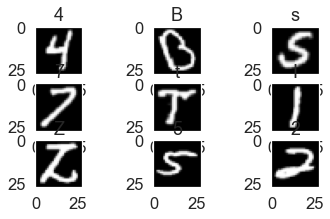

In [18]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[y_train[i]]))

### Building a Model